In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from synthid_text.detector_frequentist import weighted_frequentist_score
from synthid_text.detector_mean import weighted_mean_score
from scipy.stats import norm

In [ ]:
MODEL_NAME = "google/gemma-2b-it"
TEMPERATURE = 0.5

In [3]:
F_MODEL_NAME = MODEL_NAME.replace("/", "_")

In [8]:
padded_eli5_g_values_wm = torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu'))
padded_eli5_combined_mask_wm = torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_wm.pt", map_location=torch.device('cpu'))
padded_eli5_g_values_uwm = torch.load(f"../frequentist_experiment_data/eli5_g_values_{F_MODEL_NAME}_t={TEMPERATURE}_uwm.pt", map_location=torch.device('cpu'))
padded_eli5_combined_mask_uwm = torch.load(f"../frequentist_experiment_data/eli5_combined_mask_{F_MODEL_NAME}_t={TEMPERATURE}_uwm.pt", map_location=torch.device('cpu'))
print(np.mean(weighted_mean_score(padded_eli5_g_values_wm.numpy(), padded_eli5_combined_mask_wm.numpy())), np.mean(weighted_mean_score(padded_eli5_g_values_uwm.numpy(), padded_eli5_combined_mask_uwm.numpy())))

/var/folders/59/7skhmmps2b17ysy_h9b099zh0000gn/T/ipykernel_64486/2403036197.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  padded_eli5_g_values_wm = torch.load(f"../fre

0.52171266 0.5024207


20.0 20.0
0.5429866433143615 0.5528472282458323
0.5014131 0.51831967
100.0 100.0
0.519373812675476 0.5236339989560256
0.4988819 0.5200658
200.0 200.0
0.5160888981819153 0.5167117609283615
0.50054896 0.5195796
300.0 300.0
0.5099974870681763 0.5136450956592887
0.5004706 0.5193331
400.0 400.0
0.5134162390232087 0.5118169994780127
0.50102746 0.5193824


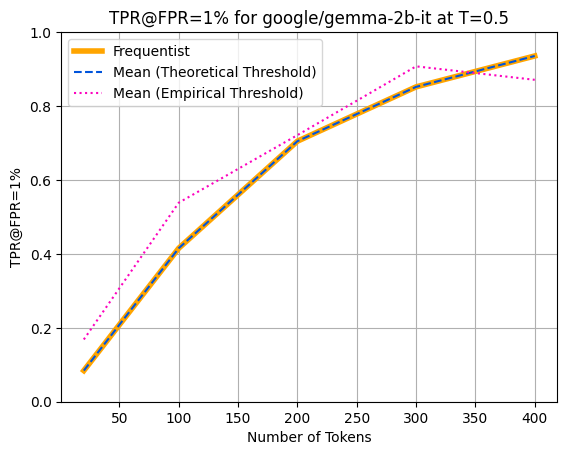

In [27]:
# True Positive at fixed False Positive Rate of 1%
# by token count, using same ones as in the paper (24 might not be exactly right)

token_counts = [20, 100, 200, 300, 400]

# For setting Mean threshold as the theoretical top-1% of unwatermark
watermarking_depth = padded_eli5_g_values_wm.shape[-1]
weights = np.linspace(start=10, stop=1, num=watermarking_depth)
weights *= watermarking_depth / np.sum(weights)
mean = watermarking_depth / 2
variance = np.sum(np.square(weights)) / 4

accs = []
mean_accs_theoritical = []
mean_accs_empirical = []

T_wm = np.sum(padded_eli5_combined_mask_wm.cpu().numpy(), axis=1)
T_uwm = np.sum(padded_eli5_combined_mask_uwm.cpu().numpy(), axis=1)

z = norm.ppf(0.975)  # ~1.96 for 95% CI

for token_count in token_counts:
    def trunc(mask):
        for i in range(len(mask)):
            true_count = 0
            for j in range(len(mask[i])):
                if mask[i][j] == 1:
                    true_count += 1
                if true_count == token_count:
                    break
            mask[i][j+1:] = 0
    diff = T_wm - token_count
    g_values = padded_eli5_g_values_wm.cpu().numpy()[diff >= 0]
    mask = padded_eli5_combined_mask_wm.cpu().numpy()[diff >= 0]
    trunc(mask)
    
    diff_uwm = T_uwm - token_count
    g_values_uwm = padded_eli5_g_values_uwm.cpu().numpy()[diff_uwm >= 0]
    mask_uwm = padded_eli5_combined_mask_uwm.cpu().numpy()[diff_uwm >= 0]
    trunc(mask_uwm)

    print(np.mean(np.sum(mask, axis=1)), np.mean(np.sum(mask_uwm, axis=1)))

    freq_scores = weighted_frequentist_score(
        g_values,
        mask,
        weights=weights,
    )
    
    n = len(freq_scores)
    acc = np.sum(-freq_scores <= 0.01) / n
    accs.append(acc)

    thresh_theoretical = norm.ppf(0.99, loc=mean, scale=np.sqrt(variance / token_count)) / watermarking_depth

    mean_score_uwm = weighted_mean_score(g_values_uwm, mask_uwm, weights)
    
    thresh_empirical = np.percentile(mean_score_uwm, 99)
    print(thresh_empirical, thresh_theoretical)

    mean_scores = weighted_mean_score(g_values, mask, weights)
    print(np.mean(mean_score_uwm), np.mean(mean_scores))

    mean_accs_theoritical.append(np.sum(mean_scores > thresh_theoretical) / n)
    mean_accs_empirical.append(np.sum(mean_scores > thresh_empirical) / n)

accs = np.array(accs)
mean_accs_theoritical = np.array(mean_accs_theoritical)
mean_accs_empirical = np.array(mean_accs_empirical)


# Plot the accuracy line
plt.plot(token_counts, accs, label='Frequentist', color='orange', linewidth=4)
plt.plot(token_counts, mean_accs_theoritical, label='Mean (Theoretical Threshold)', color='#0054db', linestyle='--')
plt.plot(token_counts, mean_accs_empirical, label='Mean (Empirical Threshold)', color='#fc03be', linestyle=':')

plt.title(f"TPR@FPR=1% for {MODEL_NAME} at T={TEMPERATURE}")
plt.xlabel("Number of Tokens")
plt.ylabel("TPR@FPR=1%")
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()
